# TextCNN

# Downloading Data and Imports

In [0]:
!curl --output dataset.zip https://archive.ics.uci.edu/ml/machine-learning-databases/00462/drugsCom_raw.zip
!unzip dataset.zip
!rm dataset.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 40.9M  100 40.9M    0     0  49.4M      0 --:--:-- --:--:-- --:--:-- 49.3M
Archive:  dataset.zip
  inflating: drugsComTest_raw.tsv    
  inflating: drugsComTrain_raw.tsv   


In [0]:
import pandas as pd
import html
from nltk.tokenize import word_tokenize,RegexpTokenizer
from nltk.corpus import stopwords 
import nltk
nltk.download('stopwords')
nltk.download('punkt')
import gensim
import numpy as np
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Using TensorFlow backend.


#Processing to Tokens

## Read dataset

In [0]:
import pandas as pd
import html
using_glove = False
def load_dataset(filename):
    df = pd.read_csv(filename, sep='\t')
    df.drop(df.columns[0], axis=1, inplace=True)
    df.drop(['drugName', 'condition', 'date', 'usefulCount'], axis=1, inplace=True)
    df['review'] = df['review'].apply(lambda x: x[1:-1])
    df['review'] = df['review'].apply(html.unescape)
    df['rating'] = df['rating'].astype('int64')
    df['label'] = df['rating']
    df.label[df['rating'] <= 4] = 0
    df.label[(df['rating'] <= 6) & (df['rating'] >= 5)] = 1
    df.label[df['rating'] >= 7] = 2
    df.drop(['rating'], axis=1, inplace=True)
    return df

df_train = load_dataset("drugsComTrain_raw.tsv")
df_test = load_dataset("drugsComTest_raw.tsv")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


## Removing Stopwords and Tokenizing the reviews

In [0]:
import nltk
from nltk.tokenize import word_tokenize,RegexpTokenizer
from nltk.corpus import stopwords 

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
tokenizer = RegexpTokenizer(r'\w+')
def func(row):
    l = tokenizer.tokenize(row['review'])
    s = [i.lower() for i in l if i not in stop_words]
    return s
df_train['processed'] = df_train.apply (lambda row: func(row), axis=1)
df_test['processed'] = df_test.apply (lambda row: func(row), axis=1)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Normalize the dataset

In [0]:
df_train = pd.concat([df_train[df_train['label']==0].sample(n=14356).reset_index(drop=True),df_train[df_train['label']==1].sample(n=14356).reset_index(drop=True),df_train[df_train['label']==2].sample(n=14356).reset_index(drop=True)],ignore_index=True)
df_test = pd.concat([df_test[df_test['label']==0].sample(n=4829).reset_index(drop=True),df_test[df_test['label']==1].sample(n=4829).reset_index(drop=True),df_test[df_test['label']==2].sample(n=4829).reset_index(drop=True)],ignore_index=True)

# Glove embedings

In [0]:
!wget "http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip"
!unzip glove.6B.zip
!rm glove.6B.zip

--2019-11-24 11:40:00--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6B.zip        100%[===================>] 822.24M  2.16MB/s    in 6m 26s  

2019-11-24 11:46:26 (2.13 MB/s) - ‘glove.6B.zip’ saved [862182613/862182613]

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [0]:
def embed(processed, w2v_dict, default_vec):
    vectors = []
    for w in processed:
        if(w in w2v_dict):
            vectors.append(w2v_dict[w])
        else:
            vectors.append(default_vec)
    vectors = np.array(vectors)
    return vectors

def embed_using_glove(df, embed_dim=50):
    # Load Glove embeddings.
    GLOVE_FILE = 'glove.6B.' + str(embed_dim) + 'd.txt'
    # Get number of vectors and hidden dimensions
    with open(GLOVE_FILE, 'r') as f:
        for i, line in enumerate(f):
            pass
    n_vec = i + 1
    hidden_dim = len(line.split(' ')) - 1
    # Find the average of all embeddings to be assigned to tokens not in the embeddings.
    # Create a word to vector dictionary for embedding.
    avg_vec = np.zeros((hidden_dim), dtype=np.float32)
    w2v_dict = {}
    v2w_dict = {}
    using_glove = True

    count = 0
    with open(GLOVE_FILE, 'r') as f:
        for line in f:
            w2v_dict[line.split(' ')[:1][0]] = np.array([float(n) for n in line.split(' ')[1:]], dtype=np.float32)
            v2w_dict[str(np.array([float(n) for n in line.split(' ')[1:]], dtype=np.float32).tolist())] = line.split(' ')[:1][0]
            avg_vec += np.array([float(n) for n in line.split(' ')[1:]], dtype=np.float32)
            count+=1
    avg_vec/=count

    df['vectors'] = df.apply(lambda row: embed(row['processed'], w2v_dict, avg_vec), axis=1)


In [0]:
df_train_glove = df_train.copy()
df_test_glove = df_test.copy()
embed_using_glove(df_train_glove, 50)
# df_train.to_pickle("train_glove_50.pckl")
embed_using_glove(df_test_glove, 50)
# df_test.to_pickle("test_glove_50.pckl")


#Word2Vec

In [0]:
!gdown --id 0B7XkCwpI5KDYNlNUTTlSS21pQmM -O word2vec.bin.gz
!gunzip word2vec.bin.gz

Downloading...
From: https://drive.google.com/uc?id=0B7XkCwpI5KDYNlNUTTlSS21pQmM
To: /content/word2vec.bin.gz
1.65GB [00:18, 88.2MB/s]


In [0]:
from gensim.models import KeyedVectors
    
w2v_model = KeyedVectors.load_word2vec_format('word2vec.bin', binary=True)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [0]:
def embed(processed, w2v_dict, default_vec):
    vectors = []
    for w in processed:
        if(w in w2v_dict):
            vectors.append(w2v_dict[w])
        else:
            vectors.append(default_vec)
    vectors = np.array(vectors)
    return vectors

In [0]:
df_train_w2v = df_train.sample(n=int(df_train.shape[0]/2)).reset_index(drop=True)
df_test_w2v = df_test.sample(n=int(df_test.shape[0])).reset_index(drop=True)
w2v_avg = np.average(w2v_model.vectors, axis=0)
df_train_w2v['vectors'] = df_train_w2v.apply(lambda row: embed(row['processed'], w2v_model, w2v_avg), axis=1)
df_test_w2v['vectors'] = df_test_w2v.apply(lambda row: embed(row['processed'], w2v_model, w2v_avg), axis=1)

In [0]:
df_train_w2v.memory_usage(deep=True)

Index               128
review         10987150
label            172272
processed      10644592
vectors      1296292080
dtype: int64

# Elmo embeddings

In [0]:
!pip install allennlp

  Created wheel for jsonnet: filename=jsonnet-0.14.0-cp36-cp36m-linux_x86_64.whl size=3320350 sha256=41284868966fe2971f9de7dfb1600796f50575f5ce0f4bddb4703da806c1e047
  Stored in directory: /root/.cache/pip/wheels/5b/b7/83/985f0f758fbb34f14989a0fab86d18890d1cc5ae12f26967bc
  Created wheel for ftfy: filename=ftfy-5.6-cp36-none-any.whl size=44553 sha256=e8b6a18ffa54c65be87cf8e2acbec902ab7b7a34606dcfb7cc270044a84d0966
  Stored in directory: /root/.cache/pip/wheels/43/34/ce/cbb38d71543c408de56f3c5e26ce8ba495a0fa5a28eaaf1046
Successfully built overrides parsimonious numpydoc word2number jsonnet ftfy


In [0]:
from allennlp.commands.elmo import ElmoEmbedder
import sys

In [0]:
def create_elmo_embeddings(elmo, documents, max_sentences = 1000):
    num_sentences = min(max_sentences, len(documents)) if max_sentences > 0 else len(documents)
    print("\n\n:: Lookup of " + str(num_sentences) + " ELMo representations. This takes a while ::")
    embeddings = []
    tokens = documents['processed'].to_numpy()
    
    documentIdx = 0
    for elmo_embedding in elmo.embed_sentences(tokens):  
        document = documents.iloc[documentIdx]
        # Average the 3 layers returned from ELMo
        avg_elmo_embedding = np.average(elmo_embedding, axis=0)             
        embeddings.append(avg_elmo_embedding)        
        
        # Some progress info
        documentIdx += 1
        percent = 100.0 * documentIdx / num_sentences
        line = '[{0}{1}]'.format('=' * int(percent / 2), ' ' * (50 - int(percent / 2)))
        status = '\r{0:3.0f}%{1} {2:3d}/{3:3d} sentences'
        sys.stdout.write(status.format(percent, line, documentIdx, num_sentences))
        
        if max_sentences > 0 and documentIdx >= max_sentences:
            break
            
    return embeddings


In [0]:
df_train_elmo = df_train.sample(n=int(df_train.shape[0]/3)).reset_index(drop=True)
df_test_elmo = df_test.sample(n=int(df_test.shape[0]/2)).reset_index(drop=True)
elmo = ElmoEmbedder(cuda_device=0) #Set cuda_device to the ID of your GPU if you have one
# elmo = ElmoEmbedder() #Set cuda_device to the ID of your GPU if you have one
df_train_elmo['vectors'] = create_elmo_embeddings(elmo, df_train_elmo, -1)
df_test_elmo['vectors'] = create_elmo_embeddings(elmo, df_test_elmo, -1)




:: Lookup of 14356 ELMo representations. This takes a while ::
100%[==================================================] 14356/14356 sentences

:: Lookup of 7243 ELMo representations. This takes a while ::
100%[==================================================] 7243/7243 sentences

# Model


In [0]:
from keras.layers import Conv1D,Concatenate,Reshape,Dense,Dropout,MaxPool1D,Input
from keras.models import Model
from keras.backend import max as max_tf 
from keras.layers import Lambda
from keras.backend import argmax
import tensorflow as tf

In [0]:
def get_new_model(sequence_length, EMBEDDING_D):
    filter_sizes = (3, 4, 5)
    num_filters = 128
    num_classes = 3
    drop_out = 0.5

    input_x = Input(shape=(sequence_length,EMBEDDING_D), name='input_x')

    # conv->max pool
    pooled_outputs = []
    for i, filter_size in enumerate(filter_sizes):
        conv = Conv1D(filters=num_filters,kernel_size=[filter_size],strides=1,padding='valid',activation='relu',
                        name=('conv_%d' % filter_size))(input_x)
        max_pool = MaxPool1D(pool_size=[sequence_length - filter_size + 1],strides=(1),
                                padding='valid',
                                name=('max_pool_%d' % filter_size))(conv)
        pooled_outputs.append(max_pool)

    # combine all the pooled features
    num_filters_total = num_filters * len(filter_sizes)
    h_pool = Concatenate(axis=1)(pooled_outputs)
    h_pool_flat = Reshape([num_filters_total])(h_pool)
    # add dropout
    dropout = Dropout(drop_out)(h_pool_flat)
    # output layer
    output = Dense(num_classes,activation='softmax',name='output')(dropout)

    model = Model(inputs=input_x, outputs=output)
    model.compile('adam', 'categorical_crossentropy', metrics=['accuracy'])
    return model



# GloVe

## Training

In [0]:
data_train, labels_train = np.array(df_train_glove['vectors']),np.array(df_train_glove['label'])
data_train = pad_sequences(data_train, maxlen=100, dtype='float32')

labels_train = to_categorical(labels_train,num_classes=3)


In [0]:
model_glove = get_new_model(sequence_length=100, EMBEDDING_D=50)
training=model_glove.fit(data_train, labels_train, epochs=100, batch_size=128, validation_split=0.1)

Train on 38761 samples, validate on 4307 samples
Epoch 1/100
38761/38761 [==============================] - 3s 87us/step - loss: 1.1576 - acc: 0.4186 - val_loss: 1.4304 - val_acc: 0.1607
Epoch 2/100
38761/38761 [==============================] - 3s 70us/step - loss: 0.9802 - acc: 0.5098 - val_loss: 1.1069 - val_acc: 0.4609
Epoch 3/100
38761/38761 [==============================] - 3s 71us/step - loss: 0.9346 - acc: 0.5477 - val_loss: 1.1672 - val_acc: 0.3898
Epoch 4/100
38761/38761 [==============================] - 3s 72us/step - loss: 0.9037 - acc: 0.5727 - val_loss: 1.2152 - val_acc: 0.3801
Epoch 5/100
38761/38761 [==============================] - 3s 71us/step - loss: 0.8669 - acc: 0.5953 - val_loss: 1.0456 - val_acc: 0.5089
Epoch 6/100
38761/38761 [==============================] - 3s 70us/step - loss: 0.8434 - acc: 0.6114 - val_loss: 0.8794 - val_acc: 0.5969
Epoch 7/100
38761/38761 [==============================] - 3s 69us/step - loss: 0.8214 - acc: 0.6251 - val_loss: 1.1235 - v

## Evaluation

In [0]:
from sklearn.metrics import classification_report
import numpy as np

data_test,labels_test = np.array(df_test_glove['vectors']),np.array(df_test_glove['label'])
data_test = pad_sequences(data_test, maxlen=100, dtype='float32')
labels_test = to_categorical(labels_test,num_classes=3)

Y_test = np.argmax(labels_test, axis=1) # Convert one-hot to index
y_pred = model_glove.predict(data_test)
y_pred = y_pred.argmax(axis=-1)
print(classification_report(Y_test, y_pred))

              precision    recall  f1-score   support

           0       0.67      0.71      0.69      4829
           1       0.59      0.75      0.66      4829
           2       0.78      0.53      0.63      4829

    accuracy                           0.66     14487
   macro avg       0.68      0.66      0.66     14487
weighted avg       0.68      0.66      0.66     14487



(3.0, 0.0)

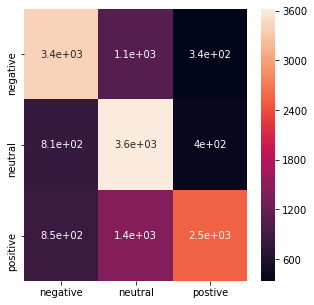

In [0]:
from sklearn import metrics
cm=metrics.confusion_matrix(Y_test,y_pred)

import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

df_cm = pd.DataFrame(cm, index = ['negative','neutral','positive'],
                  columns = ['negative','neutral','postive'])
plt.figure(figsize = (5,5))

ax = sn.heatmap(df_cm, annot=True)

bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)


# Word2Vec

## Training

In [0]:
data_train, labels_train = np.array(df_train_w2v['vectors']),np.array(df_train_w2v['label'])
data_train = pad_sequences(data_train, maxlen=100, dtype='float32')

labels_train = to_categorical(labels_train,num_classes=3)


In [0]:
model_w2v = get_new_model(sequence_length=100, EMBEDDING_D=300)
training=model_w2v.fit(data_train, labels_train, epochs=30, batch_size=128, validation_split=0.1)

Train on 19380 samples, validate on 2154 samples
Epoch 1/30
19380/19380 [==============================] - 4s 200us/step - loss: 1.0455 - acc: 0.4631 - val_loss: 0.9172 - val_acc: 0.5678
Epoch 2/30
19380/19380 [==============================] - 3s 160us/step - loss: 0.8735 - acc: 0.5970 - val_loss: 0.8487 - val_acc: 0.6230
Epoch 3/30
19380/19380 [==============================] - 3s 160us/step - loss: 0.7770 - acc: 0.6623 - val_loss: 0.8162 - val_acc: 0.6305
Epoch 4/30
19380/19380 [==============================] - 3s 159us/step - loss: 0.6970 - acc: 0.7124 - val_loss: 0.7885 - val_acc: 0.6518
Epoch 5/30
19380/19380 [==============================] - 3s 160us/step - loss: 0.6219 - acc: 0.7528 - val_loss: 0.7912 - val_acc: 0.6430
Epoch 6/30
19380/19380 [==============================] - 3s 161us/step - loss: 0.5410 - acc: 0.7954 - val_loss: 0.7801 - val_acc: 0.6620
Epoch 7/30
19380/19380 [==============================] - 3s 160us/step - loss: 0.4770 - acc: 0.8219 - val_loss: 0.7396 - v

## Evaluation

In [0]:
from sklearn.metrics import classification_report
import numpy as np

data_test,labels_test = np.array(df_test_w2v['vectors']),np.array(df_test_w2v['label'])
data_test = pad_sequences(data_test, maxlen=100, dtype='float32')
labels_test = to_categorical(labels_test,num_classes=3)

Y_test = np.argmax(labels_test, axis=1) # Convert one-hot to index
y_pred = model_w2v.predict(data_test)
y_pred = y_pred.argmax(axis=-1)
print(classification_report(Y_test, y_pred))

              precision    recall  f1-score   support

           0       0.68      0.64      0.66      4829
           1       0.56      0.66      0.60      4829
           2       0.73      0.65      0.69      4829

    accuracy                           0.65     14487
   macro avg       0.66      0.65      0.65     14487
weighted avg       0.66      0.65      0.65     14487



(3.0, 0.0)

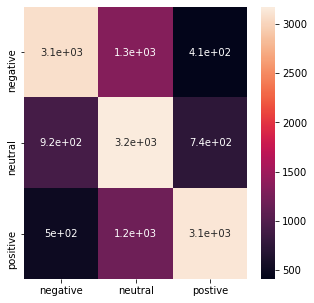

In [0]:
from sklearn import metrics
cm=metrics.confusion_matrix(Y_test,y_pred)

import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

df_cm = pd.DataFrame(cm, index = ['negative','neutral','positive'],
                  columns = ['negative','neutral','postive'])
plt.figure(figsize = (5,5))

ax = sn.heatmap(df_cm, annot=True)

bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)


# ElMo

## Training

In [0]:
data_train, labels_train = np.array(df_train_elmo['vectors']),np.array(df_train_elmo['label'])
data_train = pad_sequences(data_train, maxlen=100, dtype='float32')

labels_train = to_categorical(labels_train,num_classes=3)


In [0]:
model_elmo = get_new_model(sequence_length=100, EMBEDDING_D=1024)
training=model_elmo.fit(data_train, labels_train, epochs=20, batch_size=128, validation_split=0.1)

Train on 12920 samples, validate on 1436 samples
Epoch 1/20
12920/12920 [==============================] - 6s 497us/step - loss: 1.5609 - acc: 0.4404 - val_loss: 0.9501 - val_acc: 0.5348
Epoch 2/20
12920/12920 [==============================] - 5s 397us/step - loss: 0.8952 - acc: 0.5754 - val_loss: 0.9285 - val_acc: 0.5397
Epoch 3/20
12920/12920 [==============================] - 5s 396us/step - loss: 0.8008 - acc: 0.6371 - val_loss: 0.8783 - val_acc: 0.5975
Epoch 4/20
12920/12920 [==============================] - 5s 395us/step - loss: 0.7129 - acc: 0.6891 - val_loss: 0.8638 - val_acc: 0.6184
Epoch 5/20
12920/12920 [==============================] - 5s 395us/step - loss: 0.6448 - acc: 0.7282 - val_loss: 0.8637 - val_acc: 0.6163
Epoch 6/20
12920/12920 [==============================] - 5s 393us/step - loss: 0.5731 - acc: 0.7653 - val_loss: 0.8572 - val_acc: 0.6031
Epoch 7/20
12920/12920 [==============================] - 5s 397us/step - loss: 0.4815 - acc: 0.8064 - val_loss: 0.8803 - v

## Evaluation

In [0]:
from sklearn.metrics import classification_report
import numpy as np

data_test,labels_test = np.array(df_test_elmo['vectors']),np.array(df_test_elmo['label'])
data_test = pad_sequences(data_test, maxlen=100, dtype='float32')
labels_test = to_categorical(labels_test,num_classes=3)

Y_test = np.argmax(labels_test, axis=1) # Convert one-hot to index
y_pred = model_elmo.predict(data_test)
y_pred = y_pred.argmax(axis=-1)
print(classification_report(Y_test, y_pred))

              precision    recall  f1-score   support

           0       0.59      0.74      0.65      2413
           1       0.62      0.42      0.50      2405
           2       0.67      0.72      0.69      2425

    accuracy                           0.63      7243
   macro avg       0.63      0.62      0.62      7243
weighted avg       0.63      0.63      0.62      7243



(3.0, 0.0)

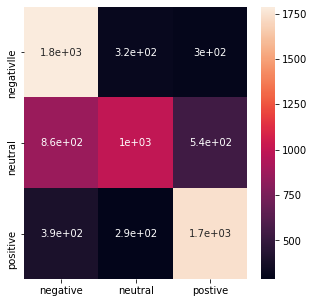

In [0]:
from sklearn import metrics
cm=metrics.confusion_matrix(Y_test,y_pred)

import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

df_cm = pd.DataFrame(cm, index = ['negativlle','neutral','positive'],
                  columns = ['negative','neutral','postive'])
plt.figure(figsize = (5,5))

ax = sn.heatmap(df_cm, annot=True)

bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
